In [1]:
import pandas as pd

In [2]:
%matplotlib inline

In [15]:
f = pd.read_csv('history.csv',index_col='epoch')

In [16]:
f.head(2)

,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
epoch,,,,,,,
0,0.268826,0.393642,0.807491,0.104432,0.690467,0.181425,NaN
1,0.411313,2.354181,0.902988,0.167104,0.537073,0.254899,NaN


In [18]:
f.shape

(10, 7)

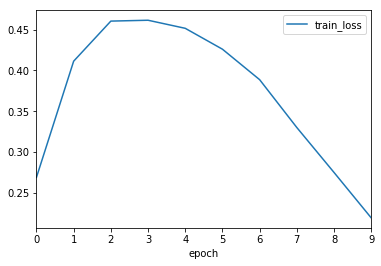

In [19]:
f.plot(y='train_loss')

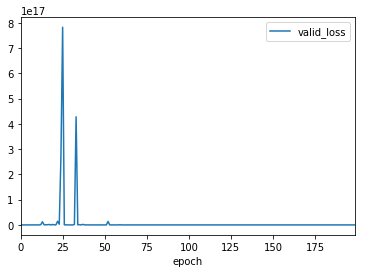

In [12]:
f.plot(y='valid_loss')

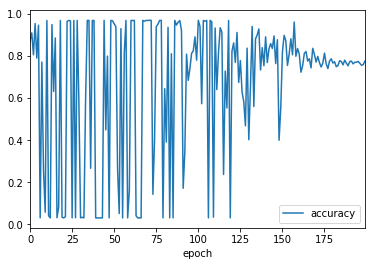

In [13]:
f.plot(y='accuracy')

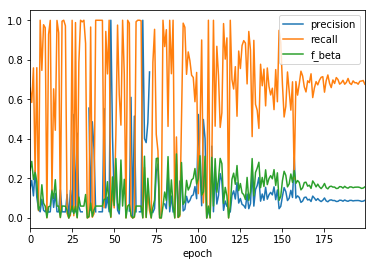

In [14]:
f.plot(y=['precision','recall','f_beta'])

In [14]:
f.accuracy[-10:]

epoch
990    0.969103
991    0.969103
992    0.969103
993    0.969103
994    0.969103
995    0.969103
996    0.969103
997    0.969103
998    0.969103
999    0.969103
Name: accuracy, dtype: float64

In [20]:
from fastai.tabular import *
from fastai.metrics import *
from fastai.callbacks import CSVLogger
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pdb
import os

In [21]:
trn_df = pd.read_csv('../train.csv',index_col='ID_code')
tst_df = pd.read_csv('../test.csv',index_col='ID_code')

trn_df.reset_index(inplace=True)
trn_df.drop('ID_code',inplace=True,axis=1)

trn_1_rows = trn_df.loc[trn_df.target == 1].index
trn_0_rows = trn_df.loc[trn_df.target == 0].index
trn_rows = trn_1_rows[-15000:].append(trn_0_rows[:20000])
val_rows = trn_1_rows[:5098].append(trn_0_rows[-159902:])

procs = [Normalize]

trn_1 = trn_df.loc[trn_df.target == 1,:]
trn_0 = trn_df.where(trn_df.target == 0)[:len(trn_1)]
trn = trn_1.append(trn_0,ignore_index=True)

data = (TabularList.from_df(trn_df,procs=procs,cont_names=tst_df.columns)
        .split_by_idx(val_rows)
       .label_from_df('target')
       .add_test(TabularList.from_df(tst_df))
       .databunch(bs=64,num_workers=16))

In [98]:
def struct_res_block(nf, dp,dense:bool=False, norm_type:Optional[NormType]=NormType.Batch, bottle:bool=True):
    "Resnet block of `nf` features fro structural data"
    #norm2 = norm_type
    #if not dense and (norm_type==NormType.Batch): norm2 = NormType.BatchZero
    nf_inner = nf//2 if bottle else nf
    return SequentialEx(nn.Conv1d(1,64),
                        nn.ReLU(),
                        nn.BatchNorm1d(nf_inner),
                        nn.Linear(nf_inner, nf),
                        nn.ReLU(),
                        nn.BatchNorm1d(nf),
                        MergeLayer(dense),
                        #nn.Linear(nf,no),
                        nn.ReLU(),
                        nn.Dropout(0.1*dp),
                        nn.BatchNorm1d(nf),)

class struct_resnet(nn.Module):
    def __init__(self,lyrs,dps):
        super().__init__()
        self.lyrs = [struct_res_block(lyrs[i],dps[i]) for i in range(0,len(lyrs))]
        self.body = nn.Sequential(*self.lyrs)
        self.head = nn.Sequential(nn.Linear(lyrs[len(lyrs)-1],128),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(128),
                                    #nn.Dropout(0.1),
                                    nn.Linear(128,64),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(64),
                                    #nn.Dropout(0.1),
                                    nn.Linear(64,2)
                                )
        self.net = nn.Sequential(self.body,self.head)

    def forward(self,A,B):
        return self.net(B)

In [128]:
learn = Learner(data,struct_resnet([200,200,200,200,200,200,200,200],dps=[0,0,0,1,1,0,0,0]),loss_func=nn.CrossEntropyLoss(),metrics=[accuracy,Precision(),Recall(),FBeta(beta=1)])

In [115]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


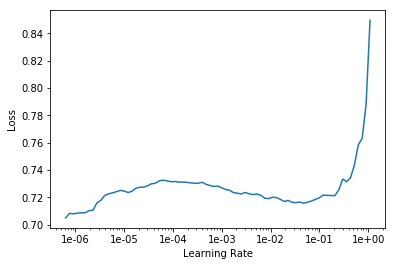

In [116]:
learn.recorder.plot()

In [131]:
learn.fit_one_cycle(250,max_lr=0.01)
sv_state()
learn.fit_one_cycle(250,max_lr=0.01)
sv_state()
learn.fit_one_cycle(250,max_lr=0.01)
sv_state()

epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.650030,0.473292,0.884224,0.080312,0.262848,0.123032,00:24
1,0.530441,0.405878,0.862242,0.123666,0.568262,0.203127,00:24
2,0.478882,0.397323,0.838085,0.120204,0.671047,0.203886,00:24
3,0.447154,0.375136,0.844800,0.124744,0.668694,0.210263,00:24
4,0.433118,0.385214,0.846800,0.125964,0.666536,0.211885,00:24
5,0.406855,0.371576,0.824764,0.113978,0.689682,0.195627,00:24
6,0.385603,0.348970,0.868291,0.136304,0.611416,0.222914,00:24
7,0.347425,0.394718,0.864576,0.133121,0.613770,0.218788,00:24
8,0.336622,0.410023,0.819867,0.109886,0.680267,0.189208,00:24
9,0.335383,0.429286,0.818594,0.108544,0.675363,0.187028,00:24


epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.001082,0.949115,0.864036,0.126218,0.574147,0.206943,00:24
1,0.002371,0.930160,0.853527,0.120754,0.595528,0.200794,00:24
2,0.001323,0.964639,0.859545,0.123819,0.583562,0.204292,00:25
3,0.001551,35.421650,0.872818,0.131512,0.556100,0.212718,00:24
4,0.002684,0.922880,0.858861,0.123676,0.586308,0.204264,00:24
5,0.001528,1.028362,0.857018,0.122510,0.588662,0.202811,00:24
6,0.002438,0.939181,0.856000,0.121276,0.586112,0.200969,00:24
7,0.002493,0.923964,0.860673,0.125257,0.586505,0.206428,00:24
8,0.002809,0.914188,0.860685,0.124512,0.581797,0.205125,00:24
9,0.004545,0.802680,0.875206,0.132641,0.548647,0.213634,00:24


epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta,time
0,0.000818,218.956177,0.859685,0.122806,0.576501,0.202480,00:24
1,0.001760,300.358643,0.850794,0.118208,0.592781,0.197111,00:24
2,0.001002,29.386845,0.858424,0.122249,0.579639,0.201913,00:24
3,0.000504,50.911758,0.867570,0.128025,0.565516,0.208784,00:25
4,0.001669,181.303253,0.852600,0.119873,0.594547,0.199519,00:24
5,0.000762,208.070663,0.855527,0.119971,0.580228,0.198830,00:24
6,0.001486,149.341995,0.851491,0.118623,0.591997,0.197642,00:24
7,0.002055,27.424482,0.860873,0.123535,0.574735,0.203359,00:25
8,0.002734,468.018341,0.838861,0.113016,0.615535,0.190969,00:24
9,0.003028,70.702499,0.870073,0.128771,0.555904,0.209105,00:25


In [75]:
len(trn_l),len(val_l)

(81900, 81900)

In [129]:
trn_l = []
val_l = []
met = []

In [130]:
def sv_state():
    trn_l.extend(learn.recorder.losses)
    val_l.extend(learn.recorder.val_losses)
    met.extend(learn.recorder.metrics)

In [135]:
met_ = np.array(met)

In [55]:
met[:,1]

array([0.125659, 0.146839, 0.578947, 0.035231, ..., 0.113237, 0.130831, 0.102349, 0.111981], dtype=float32)

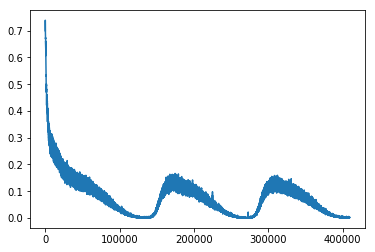

In [132]:
plt.plot(trn_l)

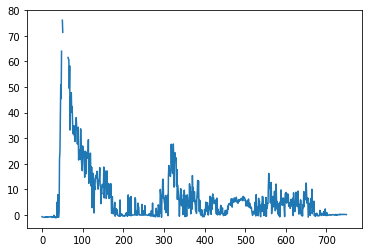

In [134]:
plt.plot(np.log(val_l))

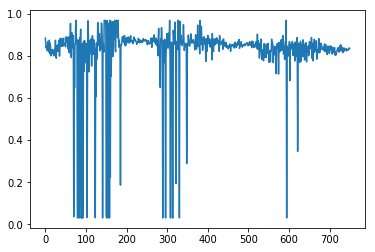

In [136]:
plt.plot(met_[:,0])

In [137]:
 p =learn.get_preds(DatasetType.Valid)

In [138]:
pred = p[0].cpu().numpy()

In [139]:
preds = pred.argmax(axis=1)

In [140]:
act = p[1].cpu().numpy()

In [141]:
act.mean(),preds.mean()

(0.030896969696969697, 0.17203030303030303)

In [142]:
locs = (act!=preds)

In [143]:
locs

array([False,  True, False, False, ...,  True, False, False, False])

In [144]:
~locs

array([ True, False,  True,  True, ..., False,  True,  True,  True])

In [145]:
ps = pred[~locs]

In [146]:
ns = pred[locs]

In [147]:
(act==preds) & (preds == 1)

array([ True, False,  True,  True, ..., False, False, False, False])

In [148]:
tp = pred[(act==preds) & (preds == 1)]

In [149]:
fp = pred[(act!=preds) & (preds == 1)]

In [150]:
tn = pred[(act==preds) & (preds == 0)]

In [151]:
fn = pred[(act!=preds) & (preds == 0)]

In [152]:
tp[:,0]

array([2.879528e-01, 2.926305e-02, 1.295951e-03, 5.037373e-04, ..., 3.766828e-04, 1.463432e-06, 4.215427e-04,
       6.284242e-06], dtype=float32)

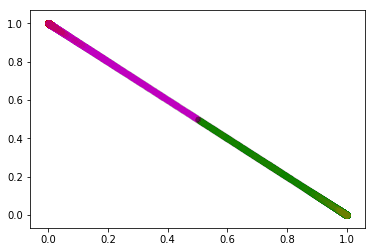

In [172]:
plt.scatter(tp[:,0],tp[:,1],c='r',alpha=0.01)
plt.scatter(tn[:,0],tn[:,1],c='g',alpha=0.01)
plt.scatter(fp[:,0],fp[:,1],c='m',alpha=0.01)
plt.scatter(fn[:,0],fn[:,1],c='y',alpha=0.01)

In [159]:
pred[:,0]

array([0.287953, 0.999502, 0.029263, 0.001296, ..., 0.006513, 0.963537, 0.999049, 0.999998], dtype=float32)

In [167]:
len(tp),len(tn),len(fp),len(fn)

(3150, 134667, 25235, 1948)

(0, 1)

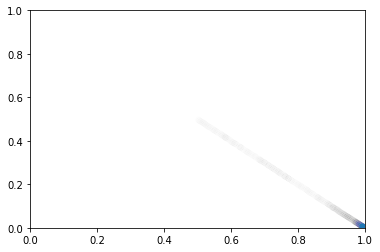

In [188]:
plt.scatter(fn[:,0],fn[:,1],alpha=0.002)
plt.xlim(0,1)
plt.ylim(0,1)

In [189]:
len(learn.recorder.losses)

136500

In [29]:
len(learn.recorder.losses)

10920

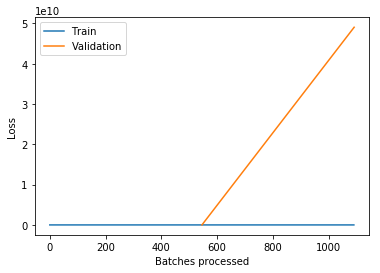

In [33]:
learn.recorder.plot_losses()

In [21]:
p = learn.get_preds(DatasetType.Valid)

In [22]:
preds = p[0].cpu().numpy()

In [23]:
preds_ = preds.argmax(axis=1)

In [24]:
act = p[1].cpu().numpy()

In [25]:
len(preds_),len(act)

(165000, 165000)

In [26]:
from sklearn.metrics import roc_auc_score

In [27]:
roc_auc_score(act,preds_)

0.5

In [28]:
(preds_ == act).mean()

0.9691030303030304

In [31]:
res = (preds_ == act)

In [32]:
res

array([False, False, False, False, ...,  True,  True,  True,  True])

In [33]:
anal = pd.DataFrame(index=range(len(res)))

In [34]:
anal['pred'] = preds_

In [35]:
anal['actual'] = act

In [36]:
anal['correct'] = res

In [42]:
anal['prob_0'] = preds[:,0]

In [43]:
anal['prob_1'] = preds[:,1]

In [45]:
anal.head(10)

,pred,actual,correct,prob_0,prob_1
0,0,1,False,0.571385,0.428615
1,0,1,False,0.571385,0.428615
2,0,1,False,0.571385,0.428615
3,0,1,False,0.571385,0.428615
4,0,1,False,0.571385,0.428615
5,0,1,False,0.571385,0.428615
6,0,1,False,0.571385,0.428615
7,0,1,False,0.571385,0.428615
8,0,1,False,0.571385,0.428615
9,0,1,False,0.571385,0.428615


In [46]:
anal.describe()

,pred,actual,prob_0,prob_1
count,165000.0,165000.000000,165000.000000,165000.000000
mean,0.0,0.030897,0.570824,0.429005
std,0.0,0.173039,0.000560,0.000389
min,0.0,0.000000,0.571385,0.428615
25%,0.0,0.000000,0.571385,0.428615
50%,0.0,0.000000,0.571385,0.428615
75%,0.0,0.000000,0.571385,0.428615
max,0.0,1.000000,0.571385,0.428615


In [47]:
anal.tail(10)

,pred,actual,correct,prob_0,prob_1
164990,0,0,True,0.571385,0.428615
164991,0,0,True,0.571385,0.428615
164992,0,0,True,0.571385,0.428615
164993,0,0,True,0.571385,0.428615
164994,0,0,True,0.571385,0.428615
164995,0,0,True,0.571385,0.428615
164996,0,0,True,0.571385,0.428615
164997,0,0,True,0.571385,0.428615
164998,0,0,True,0.571385,0.428615
164999,0,0,True,0.571385,0.428615
